# Ataques Adversos sobre una Red Neuronal

#### Importamos las librerías y módulos que necesitaremos para el desarrollo del ataque

In [0]:
import tensorflow as tf
import keras

from keras.applications.inception_v3 import InceptionV3, decode_predictions
from keras import backend as K
from keras.preprocessing import image

import matplotlib.pyplot as plt
import matplotlib.image as pltimg 

import numpy as np

from time import time

from PIL import Image

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

Using TensorFlow backend.


**Nota:** Si no va a utilizar Google Collab, omite las dos siguentes celdas,coloca la imagen original en el mismo directorio que este notebook y siga los pasos descritos **(no olvide de cambiar el nombre de la imagen por la que vaya a utilizar)**

In [0]:
from google.colab import drive  #Montamos como dispositivo nuestra carpeta de Google Drive para poder acceder a los contenidos que tenemos en la nube
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Accedemos al directorio de trabajo del proyecto
% cd drive/My\ Drive/AtaquesAdversarios  

/content/drive/My Drive/AtaquesAdversarios


In [0]:
modelo = InceptionV3() # Cargamos el modelo














96116736/96112376 [==============================] - 2s 0us/step


In [0]:
def normalizar(img , normalizar = True): # Transforma la imagen que le pasemos de rango (0 - 255) a (-1 - 1) y viceversa
  if normalizar:
    img /= 255 #Rango (0 - 1)
    img -= 0.5 #Rango (-0.5 - 0.5)
    img *= 2 #Rango (-1 - 1)
  else:
    img /= 2  #Rango (-0.5 - 0.5)
    img += 0.5 #Rango (0 - 1)
    img *= 255 #Rango (0 - 255)

In [0]:
def visualizar(img): # Realiza un plot de la imagen que le pasemos
  plt.rcParams['figure.figsize'] = (9, 9) # Cambiamos el tamaño de la imagen para que se vea mas grande
  plt.imshow(img[0].astype(np.uint8))
  plt.show()

In [0]:
def cargarImagen(img_name , normalizarImagen = False): # Carga y redimensiona una imagen para poder utilizarla en el modelo inception V3

  # Cargamos la imagen como array y le damos el tamaño que se nos especifica en la documentacion del modelo para su correcto funcionamiento
  img = image.img_to_array(image.load_img(img_name , target_size=(299, 299))) 

  if normalizarImagen: # Normalizamos directamente la imagen si queremos ahorrandonos un paso adicional posteriormente
    normalizar(img , normalizar = True) # Ponemos la imagen en escala (-1 - 1)

  #Incluimos una dimensión adicional ya que inceptionV3 requiere de 4 dimensiones para la entrada
  img = img.reshape([1 , img.shape[0], img.shape[1], img.shape[2]]) 

  print(img.shape) #Mostramos las dimensiones

  return img

In [0]:
def predecir(img):
  prediccion = modelo.predict(img) # Almacenamos el resultado de la predicción
  print(*decode_predictions(prediccion)[0] , sep="\n") # Utilizamos este método para poder interpretar facilmente el valor de la predicción
  return prediccion

In [0]:
def comparar(img1 , img2 , visualizarRuido = False): # Hace un plot contiguo de las dos imágenes que le pasemos

  if visualizarRuido:

    fig , (ax1, ax2 , ax3) = plt.subplots(1, 3, figsize=(18, 18))

    imgplot1 = ax1.imshow(img1[0].astype(np.uint8))
    ax1.set_title('Original')
  
    ruido = img2 - img1

    imgplot2 = ax2.imshow(ruido[0].astype(np.uint8))
    ax2.set_title('Ruido')

    imgplot3 = ax3.imshow(img2[0].astype(np.uint8))
    ax3.set_title('Modificada')
  
  else:
    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 18))

    imgplot1 = ax1.imshow(img1[0].astype(np.uint8))
    ax1.set_title('Original')
  
    imgplot2 = ax2.imshow(img2[0].astype(np.uint8))
    ax2.set_title('Modificada')

In [0]:
def guardar(img , nombre): # Guarda la imagen en el punto de montaje
  imagen = Image.fromarray(img[0].astype(np.uint8))
  imagen.save(nombre)

In [0]:
img_original = cargarImagen("perro.jpg")

(1, 299, 299, 3)


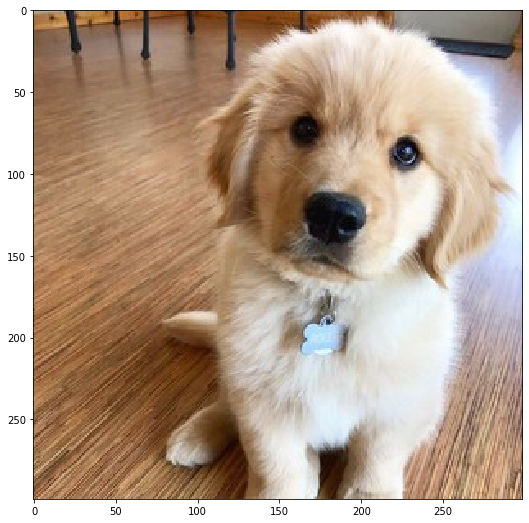

In [0]:
visualizar(img_original)

In [0]:
normalizar(img_original) # Ponemos la imagen en escala (-1 - 1)

![texto alternativo](https://drive.google.com/uc?id=1ua4T_2YdwnZfVhnLug_Md7_ruQb39IQs)

In [0]:
prediccion = predecir(img_original)

40960/35363 [==================================] - 0s 0us/step
('n02099601', 'golden_retriever', 0.8545767)
('n02099712', 'Labrador_retriever', 0.05170125)
('n02108551', 'Tibetan_mastiff', 0.004771749)
('n04409515', 'tennis_ball', 0.0033893639)
('n03223299', 'doormat', 0.0023314971)


## Método para modificar la imagen

En este método vamos a **redefinir el grafo** que representa la red neuronal para implementar la funcionalidad que queremos conseguir, en este caso queremos obtener la probabilidad de que nuestra imagen sea de una clase predeterminada (clase con la que queremos "confundir" a la red) y realizar distintas modificaciones sobre dicha imagen para que poco a poco la probabilidad de que nuestra imagen pertenezca a esta clase aumente (utilizando el descenso por gradiente para ver que pixeles tenemos que modificar y cuanto)

Página para ver la etiqueta de las 1000 clases del modelo inception

[Click para ver](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)

![texto alternativo](https://drive.google.com/uc?id=1_aq2WQWk5KnVABsYYV5_l1WD4rMfTxav)

In [0]:
def modificarImagen(img , claseDestino , tasaErrorRed = 0.95 , cotaInf = 0.01 , cotaSup = 0.01 , percibirCambios = True ): 

  capa_entrada = modelo.layers[0].input  # Cogemos la capa de entrada del modelo 
  capa_salida = modelo.layers[-1].output # Cogemos la capa de salida del modelo

  probabilidad_nueva_clase = capa_salida[0 , claseDestino] # Guardamos en la variable el % que nos devuelve la red para la clase con la que queremos engañarla

# La variable optimizador contendrá las modificaciones que tenemos que realizar sobre la imagen
  optimizador = K.gradients(probabilidad_nueva_clase , capa_entrada)[0] # Definimos el descenso por gradiente entre la perdida y la entrada que le pasemos

  # Definimos la función gradiente en la que pasandole la entrada del modelo, nos devuelve el gradiente (modificación que tenemos que realizar en la imagen 
  #para optimizar el error) y la pérdida --> El % de error de la red con respecto a los cambios realizados

  funcion_modificadora = K.function([capa_entrada , K.learning_phase()], [optimizador , probabilidad_nueva_clase]) 

  imagenMod = np.copy(img) # Creamos una copia de la imagen original para realizar en ella las modificaciones

  error_red = 0.0 

  # Definimos las cotas superior e inferior de los parámetros para que las modificaciones no sobrepasen ese intervalo y conseguir así que
  # las modificaciones sean tan pequeñas que sean imperceptibles para el ojo humano
  
  max_mod = img + cotaSup 
  min_mod = img - cotaInf

  tiempo_inicial = time() # Guardamos el instante de tiempo en que se inicia el bucle para calcular luego la duración de todo el proceso

  iteraciones = 0 # Vemos cuantas modificaciones realizamos sobre la imagen para conseguir confundir a la red

  while error_red < tasaErrorRed:
    
    # Utilizamos la función definida anteriormente para obtener el incremento que hay que realizar sobre la imagen y la pérdida (error) de la red
    # con la imagen que le proporcionamos antes de modificar

    ruido , error_red = funcion_modificadora([imagenMod , 0])
      
    imagenMod += ruido # Realizazmos las modificaciones sobre la imagen

    if percibirCambios == False:      
      # Fijamos los valores de la imagen para que no puedan aumentar ni disminuir de la cota definida anteriormente
      imagenMod = np.clip(imagenMod , min_mod , max_mod) 
      # Fijamos los valores de -1 y 1 para que las modificaciones no se salgan del rango en el que se encuentra definida la imagen
      imagenMod = np.clip(imagenMod , -1 , 1) 

    clear_output(wait=True) # Limpiamos la salida en cada iteración para que se vea mejor todo

    iteraciones += 1

    print("Error de la Red: {}".format(error_red)) # Mostramos el error que estamos obteniendo con las modificaciones

  tiempo_final = time() # Volvemos a obtener el tiempo a la salida del bucle
  
  tiempo_ejecucion = tiempo_final - tiempo_inicial # Calculamos el tiempo de ejecucion de todo el proceso

  print("=======================================================================================================")
  print("El tiempo de ejcución ha sido: {:.2f} segundos".format(tiempo_ejecucion)) # Mostramos el tiempo que ha durado todo el proceso de modificación
  print("Se han realizado {} modificaciones sobre la imagen".format(iteraciones))

  return imagenMod

In [0]:
img_mod1 = modificarImagen(img = img_original , claseDestino=69 , percibirCambios=True) # Clase 963 = Pizza
normalizar(img_mod1 , normalizar=False) # Ponemos la imagen en escala (0 - 255) para poder visualizarla a color

Error de la Red: 0.9543400406837463
El tiempo de ejcución ha sido: 57.67 segundos
Se han realizado 1394 modificaciones sobre la imagen


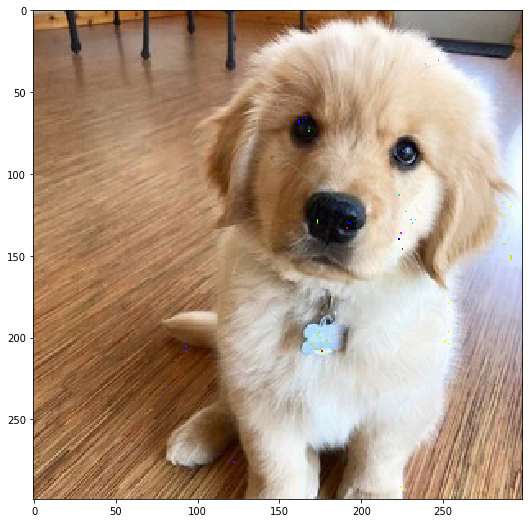

In [0]:
visualizar(img_mod1)

In [0]:
guardar(img_mod1 , "Modificacion1.png")

In [0]:
normalizar(img_mod1) # Ponemos la imagen en escala (-1 - 1) para ver que nos devuelve ahora la red

![texto alternativo](https://drive.google.com/uc?id=172_OXwiMaFV39dp_dooxgfsu0kOhBamD)

In [0]:
prediccion_mod1 = predecir(img_mod1)

('n01768244', 'trilobite', 0.997663)
('n01990800', 'isopod', 0.0005652913)
('n02098413', 'Lhasa', 0.00015649345)
('n04209133', 'shower_cap', 0.00011150642)
('n02807133', 'bathing_cap', 0.00010361238)


#### Realizamos una segunda modificación pero esta vez vamos a realizar cambios pequeños para que la imagen generada en la modificación y la original sean iguales a la vista humana.

![texto alternativo](https://drive.google.com/uc?id=1_aq2WQWk5KnVABsYYV5_l1WD4rMfTxav)

In [0]:
img_mod2 = modificarImagen(img = img_original , claseDestino=69 , percibirCambios = False) # Clase 963 = Pizza
normalizar(img_mod2 , normalizar = False) # Ponemos la imagen en escala (0 - 255) para poder visualizarla a color

Error de la Red: 0.984582781791687
El tiempo de ejcución ha sido: 59.24 segundos
Se han realizado 1423 modificaciones sobre la imagen


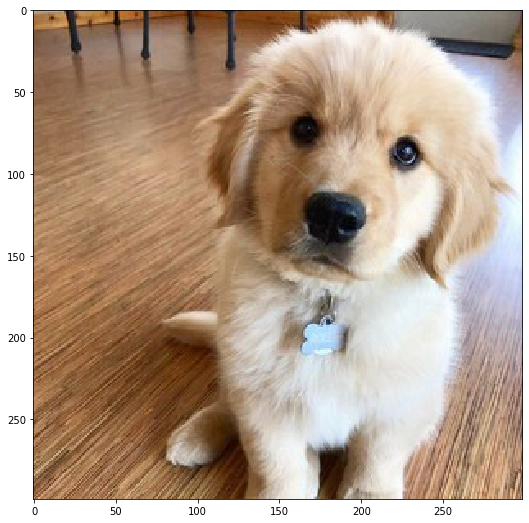

In [0]:
visualizar(img_mod2)

In [0]:
guardar(img_mod2 , "Modificacion22.png")

In [0]:
normalizar(img_mod2) # Ponemos la imagen en escala (-1 - 1) para ver que nos devuelve ahora la red

![texto alternativo](https://drive.google.com/uc?id=172_OXwiMaFV39dp_dooxgfsu0kOhBamD)

In [0]:
prediccion_mod2 = predecir(img_mod2)

('n01768244', 'trilobite', 0.9893177)
('n01990800', 'isopod', 0.0019320151)
('n04153751', 'screw', 0.00078677275)
('n02108551', 'Tibetan_mastiff', 0.00048313625)
('n02099601', 'golden_retriever', 0.00033772681)


###Añadimos comparativa


In [0]:
# Ponemos la imagen original y las modificadas en color para poder compararla con las modificadas y ver si existen cambios perceptibles entre ambas
normalizar(img_original, normalizar=False)
normalizar(img_mod1, normalizar=False)
normalizar(img_mod2 , normalizar=False) 

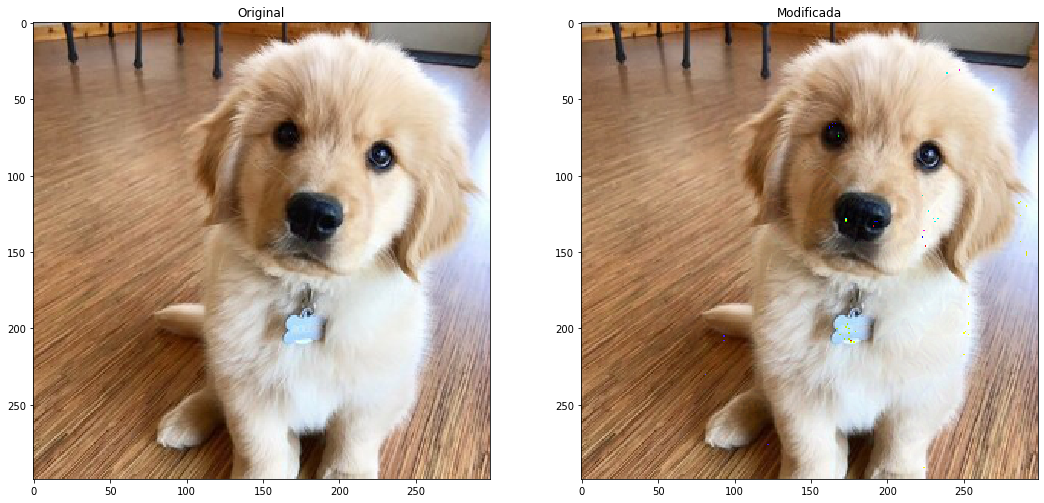

In [0]:
# Comparamos la imagen original con la primera modificación que hemos realizado (perceptible por el ojo hunano)
comparar(img_original , img_mod1) 

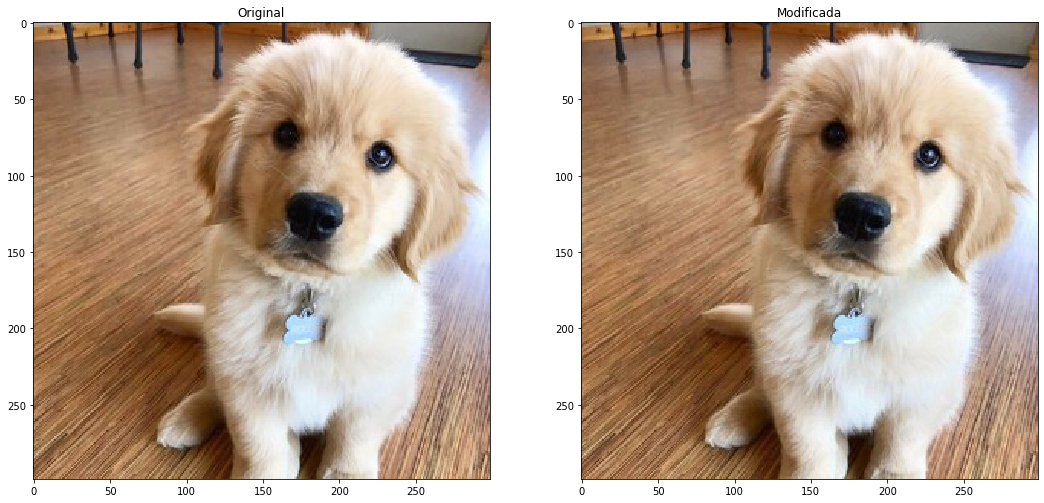

In [0]:
# Comparamos la imagen original con la segunda modificación que hemos realizado (NO perceptible por el ojo hunano)
comparar(img_original , img_mod2) 

##Visualizamos las modificaciones que se han añadido a las imágenes

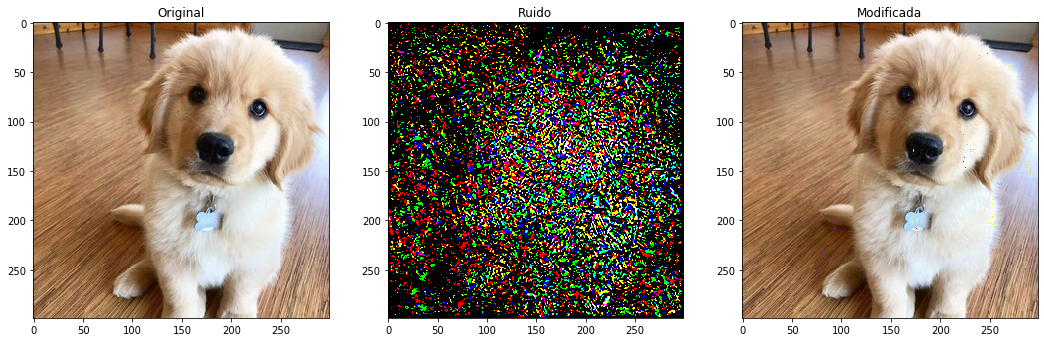

In [0]:
comparar(img_original , img_mod1 , visualizarRuido=True) # Ruido en la primera modificación (perceptible por el ojo humano)

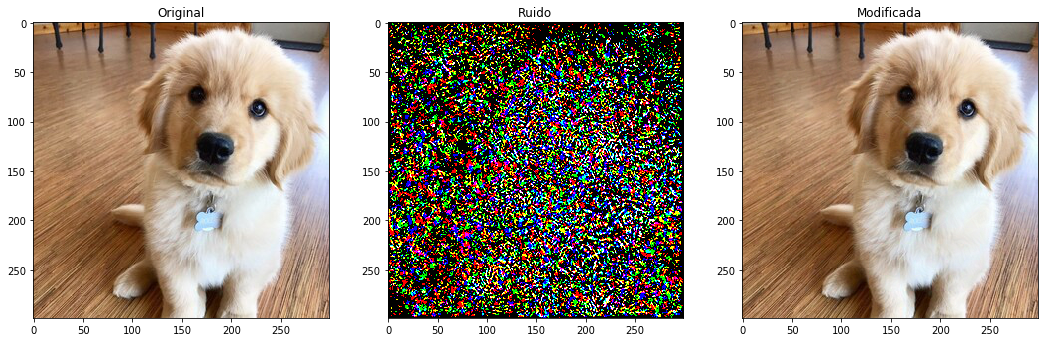

In [0]:
comparar(img_original , img_mod2 , visualizarRuido=True) # Ruido en la primera modificación (imperceptible por el ojo humano)